In [1]:
import pandas as pd
import torch
import numpy as np
from timeit import default_timer as timer
from sklearn.metrics import cohen_kappa_score, accuracy_score
from transformers import (BertTokenizer,
                          BertModel,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          BertForSequenceClassification,
                          TrainingArguments,
                          Trainer)
import pynvml
import datetime
import os
from psutil import virtual_memory
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


# System info
pynvml.nvmlInit()
clear_output()

time_limit = datetime.datetime.now() + datetime.timedelta(hours=21)
ram_gb = virtual_memory().total / 1e9

gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
gpu_name = pynvml.nvmlDeviceGetName(gpu_handle)
gpu_memory = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle).total / (2 ** 30)

print(f"CPU cores: {os.cpu_count()}\n"
      f"Total RAM: {ram_gb:.2f} GB\n"
      "-------------------------------\n"
      f"GPU name: {(gpu_name, 'utf-8')}\n"
      f"GPU memory: {gpu_memory:.2f} GB\n"
      "-------------------------------\n"
      f"Runtime limit: {time_limit.strftime('%d/%m/%Y %H:%M')}")

pynvml.nvmlShutdown()

CPU cores: 8
Total RAM: 8.41 GB
-------------------------------
GPU name: ('NVIDIA GeForce GTX 1650', 'utf-8')
GPU memory: 4.00 GB
-------------------------------
Runtime limit: 23/04/2024 19:02


In [1]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [2]:
# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_csv = os.path.join(parent_dir[0], "Pre-processamento\\noticias_dados_limpos.csv")

df = pd.read_csv(caminho_csv)

df.head()

,Texto,Categoria
0,O Podemos decidiu expulsar o deputado federal ...,Real
1,"Bolsonaro é um liberal completo, diz president...",Real
2,Ministro do STF libera Andrea Neves de prisão ...,Real
3,"Apesar da abundância, cresce preocupação com p...",Real
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",Real


In [5]:
# Aplicação do LabelEncoder para transformar a variável categórica 'Categoria' em uma variável numérica 'label'.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['label'] = le.fit_transform(df['Categoria'])

df['Categoria'].unique(), df['label'].unique()

(array(['Real', 'Falso'], dtype=object), array([1, 0]))

Text(0, 0.5, 'Number of texts')

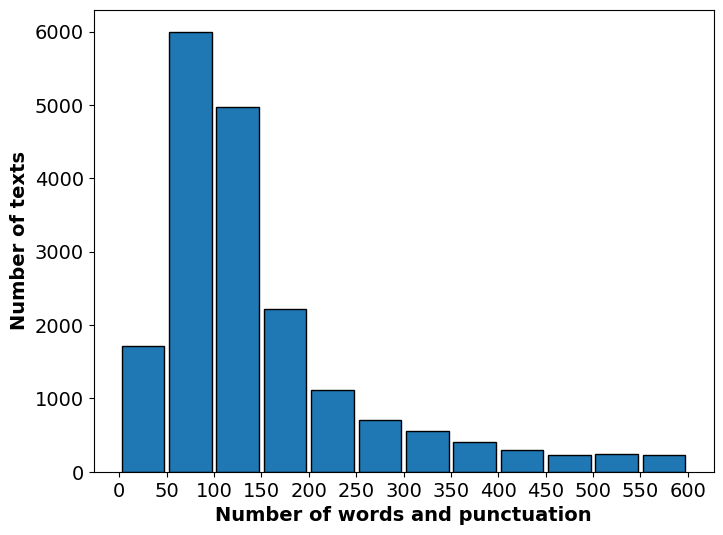

In [6]:
import re
def count_words(texts):
    counts = []
    for text in texts:
        num_words = len(re.findall(r"[\w']+|[.,!?;:/\"]", text))
        counts.append(num_words)
    return np.array(counts)


counts = count_words(df["Texto"].values)
intervals = list(range(0, 601, 50))

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.hist(counts, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervals)
plt.xticks(intervals)

plt.xlabel("Number of words and punctuation", fontsize=14, fontweight="bold")
plt.ylabel("Number of texts", fontsize=14, fontweight="bold")

In [7]:
DATA_SPLIT_PC = [0.75, 0.125, 0.125]
assert sum(DATA_SPLIT_PC) == 1

train_df = df.sample(frac=DATA_SPLIT_PC[0])
val_df = df.drop(train_df.index).sample(n=int(len(df) * DATA_SPLIT_PC[1]))
test_df = df.drop(train_df.index).drop(val_df.index)

print("> Training samples: %d" % len(train_df))
print("> Validation samples: %d" % len(val_df))
print("> Test samples: %d" % len(test_df))

> Training samples: 16713
> Validation samples: 2785
> Test samples: 2786


In [8]:
# BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased",
                                               do_lower_case=False)

In [9]:
class BertFakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer=bert_tokenizer, max_seq_length=128):
        self._labels = torch.tensor(df["label"].values, dtype=torch.long)
        self._encodings = {"input_ids": [],
                           "token_type_ids": [],
                           "attention_mask": []}

        for txt in df["Texto"].values:
            enc_dict = tokenizer.encode_plus(
                text=txt,
                add_special_tokens=True,
                max_length=max_seq_length,
                return_token_type_ids=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt",
                truncation=True,
            )
            for k, v in enc_dict.items():
                self._encodings[k].append(v[0])
    
    def __getitem__(self, idx):
        item = {key: value[idx] for key, value in self._encodings.items()}
        item["labels"] = self._labels[idx]
        return item

    def __len__(self):
        return len(self._labels)

In [10]:
train_ds = BertFakeNewsDataset(train_df)
val_ds = BertFakeNewsDataset(val_df)
test_ds = BertFakeNewsDataset(test_df)

In [11]:
train_ds[0]

{'input_ids': tensor([  101,  9715,   125,   496,   446, 22303,  7674,  4073,  3489,   221,
          6009,   125,  3191,   125,  4848,   221,   123,  7907,  3559,   119,
         12388,   477,   221,   123,  9588,   125,  1426,   730,  7173, 18304,
           138, 16861,   130,  1242,   262,  5370,   229,  1448,   118, 14258,
           113,   542,   114,   119,   119,   177,  9715,   125,   496,   446,
         22303,   117,   202,  1410,   171,  5142,   117,  6540,   229,  1448,
           118, 14258,   113,   542,   114,   146,   902,  1013,   125,  4073,
          3489,   221,   123,  6009,   125,  3191,   125,  4848,   221,   123,
          7907,  3559,   113,   278, 22311,   114,   119,  3163,   117,   259,
         15242,  9057,  9950,  3191,   125, 13200,   119, 10944,   146,   902,
          1013,   117,  6224, 14469, 22281,  1426,   730,  7173, 18304,   138,
         16861,   130,  1242,   221,  2392,   122,  1700,   173,  2576,   320,
          5155,  5882,   125,   257,   

In [12]:
# Carregando o BERT
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=2,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
sample = {k: torch.unsqueeze(v, 0)
          for k, v in train_ds[0].items()}

start_time = timer()
print(f"Output: {model(**sample)}")
print(f"Time: {timer() - start_time:.5f}s")

Output: SequenceClassifierOutput(loss=tensor(0.5792, grad_fn=<NllLossBackward0>), logits=tensor([[-0.4018, -0.1592]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Time: 0.29897s


In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "qwk": cohen_kappa_score(labels, predictions, weights="quadratic"),
    }

In [15]:
train_args = TrainingArguments(
    output_dir="C://Users//mathe//OneDrive//Área de Trabalho//Detector//Modelos//BERT//Treinamento",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    save_steps=1000,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

In [16]:
#Treina modelo
trainer.train()

  0%|          | 0/2615 [00:00<?, ?it/s]

{'loss': 0.1479, 'grad_norm': 9.83797836303711, 'learning_rate': 2.0219885277246655e-05, 'epoch': 0.96}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.06012650951743126, 'eval_accuracy': 0.9827648114901256, 'eval_qwk': 0.9654695526075292, 'eval_runtime': 40.143, 'eval_samples_per_second': 69.377, 'eval_steps_per_second': 2.192, 'epoch': 1.0}
{'loss': 0.0385, 'grad_norm': 15.58521842956543, 'learning_rate': 1.543977055449331e-05, 'epoch': 1.91}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.06113103777170181, 'eval_accuracy': 0.985278276481149, 'eval_qwk': 0.9704822698445565, 'eval_runtime': 39.528, 'eval_samples_per_second': 70.456, 'eval_steps_per_second': 2.226, 'epoch': 2.0}
{'loss': 0.0191, 'grad_norm': 0.10160158574581146, 'learning_rate': 1.0659655831739961e-05, 'epoch': 2.87}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.07715130597352982, 'eval_accuracy': 0.9859964093357271, 'eval_qwk': 0.9719354646170844, 'eval_runtime': 39.297, 'eval_samples_per_second': 70.871, 'eval_steps_per_second': 2.239, 'epoch': 3.0}
{'loss': 0.0064, 'grad_norm': 0.005541304592043161, 'learning_rate': 5.879541108986616e-06, 'epoch': 3.82}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.08473493158817291, 'eval_accuracy': 0.9842010771992818, 'eval_qwk': 0.9683449475911782, 'eval_runtime': 39.066, 'eval_samples_per_second': 71.29, 'eval_steps_per_second': 2.253, 'epoch': 4.0}
{'loss': 0.0028, 'grad_norm': 0.004079694394022226, 'learning_rate': 1.0994263862332695e-06, 'epoch': 4.78}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.07798890024423599, 'eval_accuracy': 0.9874326750448833, 'eval_qwk': 0.9748070565570273, 'eval_runtime': 38.704, 'eval_samples_per_second': 71.956, 'eval_steps_per_second': 2.274, 'epoch': 5.0}
{'train_runtime': 25718.0353, 'train_samples_per_second': 3.249, 'train_steps_per_second': 0.102, 'train_loss': 0.04108210174975842, 'epoch': 5.0}


TrainOutput(global_step=2615, training_loss=0.04108210174975842, metrics={'train_runtime': 25718.0353, 'train_samples_per_second': 3.249, 'train_steps_per_second': 0.102, 'total_flos': 5496718835289600.0, 'train_loss': 0.04108210174975842, 'epoch': 5.0})

In [17]:
# Avalia o modelo
trainer.evaluate(train_ds)

  0%|          | 0/523 [00:00<?, ?it/s]

{'eval_loss': 0.0005715509178116918,
 'eval_accuracy': 0.9998803326751631,
 'eval_qwk': 0.9997606420207433,
 'eval_runtime': 247.77,
 'eval_samples_per_second': 67.454,
 'eval_steps_per_second': 2.111,
 'epoch': 5.0}

In [18]:
trainer.evaluate(val_ds)

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.07798890024423599,
 'eval_accuracy': 0.9874326750448833,
 'eval_qwk': 0.9748070565570273,
 'eval_runtime': 41.723,
 'eval_samples_per_second': 66.75,
 'eval_steps_per_second': 2.109,
 'epoch': 5.0}

In [19]:
trainer.evaluate(test_ds)

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.07975485175848007,
 'eval_accuracy': 0.9881550610193827,
 'eval_qwk': 0.9762910859867832,
 'eval_runtime': 41.96,
 'eval_samples_per_second': 66.397,
 'eval_steps_per_second': 2.097,
 'epoch': 5.0}

In [20]:
model.save_pretrained("C://Users//mathe//OneDrive//Área de Trabalho//Detector//Modelos//BERT//Treinamento")

100%|██████████| 88/88 [07:40<00:00,  5.23s/it]


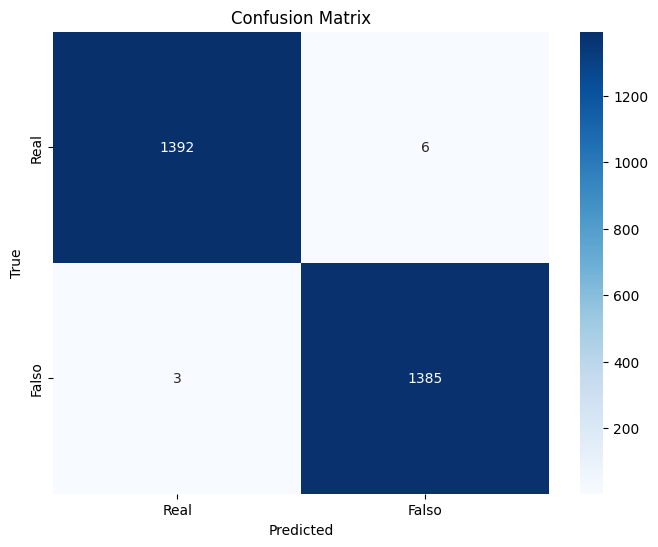

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm

# Encontra diretorio atual
atual_dir = os.getcwd()

parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_csv = os.path.join(parent_dir[0], "Pre-processamento\\noticias_dados_limpos.csv")

df = pd.read_csv(caminho_csv)

# Aplicação do LabelEncoder para transformar a variável categórica 'Categoria' em uma variável numérica 'label'.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['label'] = le.fit_transform(df['Categoria'])

df['Categoria'].unique(), df['label'].unique()

DATA_SPLIT_PC = [0.75, 0.125, 0.125]
assert sum(DATA_SPLIT_PC) == 1

train_df = df.sample(frac=DATA_SPLIT_PC[0])
val_df = df.drop(train_df.index).sample(n=int(len(df) * DATA_SPLIT_PC[1]))
test_df = df.drop(train_df.index).drop(val_df.index)

# Load your BERT model
model_path = "C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Detector\\Modelos\\BERT\\Treinamento"
model = BertForSequenceClassification.from_pretrained(model_path)

# Define tokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

def predict(model, input_ids, attention_masks, batch_size=32):
    predicted_labels = []
    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size)):
            batch_input_ids = input_ids[i:i+batch_size]
            batch_attention_masks = attention_masks[i:i+batch_size]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            batch_predicted_labels = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

def preprocess_data(df, tokenizer, max_seq_length=128):
    encodings = tokenizer(df["Texto"].tolist(), 
                           add_special_tokens=True,
                           max_length=max_seq_length,
                           padding="max_length",
                           truncation=True,
                           return_token_type_ids=False,
                           return_attention_mask=True,
                           return_tensors="pt")
    return encodings

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class BertFakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_seq_length=128):
        self._labels = torch.tensor(df["label"].values, dtype=torch.long)
        self._encodings = tokenizer(df["Texto"].tolist(), 
                                     add_special_tokens=True,
                                     max_length=max_seq_length,
                                     padding="max_length",
                                     truncation=True,
                                     return_token_type_ids=False,
                                     return_attention_mask=True,
                                     return_tensors="pt")

    def __getitem__(self, idx):
        item = {key: value[idx] for key, value in self._encodings.items()}
        item["labels"] = self._labels[idx]
        return item

    def __len__(self):
        return len(self._labels)

# Carregar os dados de teste usando BertFakeNewsDataset
test_ds = BertFakeNewsDataset(test_df, tokenizer)

# Obter os exemplos de entrada e os rótulos verdadeiros
input_ids = test_ds._encodings["input_ids"]
attention_masks = test_ds._encodings["attention_mask"]
true_labels = test_ds._labels

# Fazer previsões usando o modelo
predicted_labels = predict(model, input_ids, attention_masks)

# Plotar a matriz de confusão
labels = df['Categoria'].unique()
plot_confusion_matrix(true_labels, predicted_labels, labels)


In [4]:
from sklearn.metrics import accuracy_score, f1_score

# Calcula a acurácia
accuracy = accuracy_score(true_labels, predicted_labels)

# Calcula o F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1-score:", f1)


Accuracy: 0.9967695620961953
F1-score: 0.9967695708363921
